In [160]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from sentinelhub import SHConfig
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)
import folium
from tqdm import tqdm
import math

In [161]:
from sentinelhub import SHConfig
from dotenv import load_dotenv
import os
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
from sentinelhub import CRS, BBox, bbox_to_dimensions
import cv2
import ee

In [162]:
config_sentinel = SHConfig(sh_client_id=os.environ.get("sh_client_id"), sh_client_secret=os.environ.get("sh_client_secret"))

In [163]:
evalscript_lsm = """
function setup() {
  return {
    input: ["B02", "B03", "B04", "B08", "B11"],
    output: { bands: 3 },
  };
}

function stretch(val, min, max) { return (val - min) / (max - min); }

function evaluatePixel(sample) {
  var bsi = ((sample.B11 + sample.B04) - (sample.B08 + sample.B02)) / ((sample.B11 + sample.B04) + (sample.B08 + sample.B02));
  var NDVI = index(sample.B08, sample.B04);
  var NDWI = index(sample.B03, sample.B08);

  // Set unavailable regions to black (e.g., non-land areas, invalid data)
  if (!isFinite(bsi) || !isFinite(NDVI) || !isFinite(NDWI) || sample.B02 === 0) {
    return [0, 0, 0]; // Black
  }

  if (NDWI > 0.15) {
    return [0, 0.2, 1.0 * NDWI];
  }
  if ((sample.B11 > 0.8) || (NDVI < 0.15)) {
    return [1.5, 0.7, -1];
  }
  if (NDVI > 0.25) {
    return [0, 0.2 * NDVI, 0];
  } else {
    return [3.5 * bsi, 0.3, 0];
  }
}
"""

In [164]:
from math import cos, radians

def add_km_to_coordinates(lat, lon, d_lat_km, d_lon_km):
    km_per_deg_lat = 111.32  # Constant
    km_per_deg_lon = 111.32 * cos(radians(lat))  # Adjusted for latitude
    new_lat = lat + (d_lat_km / km_per_deg_lat) # Convert km to degrees
    new_lon = lon + (d_lon_km / km_per_deg_lon)

    return new_lat, new_lon

In [165]:
grid = 3
box_dim = 400 #450 km
min_lat, min_lon  = 25.575306, 79.031548
# max_lat, max_lon = add_km_to_coordinates(min_lat, min_lon, box_dim, box_dim)
max_lat, max_lon = add_km_to_coordinates(min_lat, min_lon, box_dim * (grid - 1), box_dim * (grid - 1))

# lat = [add_km_to_coordinates(min_lat, 0, i*box_dim, i*box_dim)[0] for i in range(grid)]
# lon = [add_km_to_coordinates(0, min_lon, i*box_dim, i*box_dim)[1] for i in range(grid)]

lat = [add_km_to_coordinates(min_lat, min_lon, i * box_dim, 0)[0] for i in range(grid)]
lon = [add_km_to_coordinates(min_lat, min_lon, 0, i * box_dim)[1] for i in range(grid)]

latlons = []
for i in range(len(lat)-1):
    for k in range(len(lon)-1):
        latlons.append((lat[k], lon[i], lat[k+1], lon[i+1]))

m = folium.Map(
    location=[(min_lat + max_lat) / 2, (min_lon + max_lon) / 2],
    zoom_start=4,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri'
)

cordinates = []
for k in latlons:
    cord = [(k[0], k[1]), (k[2], k[3])]
    cordinates.append([k[1], k[0], k[3], k[2]])
    folium.Rectangle(cord, color='red', fill='pink',fill_opcity=0.5).add_to(m)
m

In [166]:
def get_suseptibility_mapping(cordinates, box_dim=400, date_start = "2024-04-07", date_end = "2024-04-07"):
    min_lat, min_lon  = cordinates

    max_lat, max_lon = add_km_to_coordinates(min_lat, min_lon, box_dim, box_dim)

    cords = [min_lon, min_lat, max_lon, max_lat]

    bbox = BBox(bbox=cords, crs=CRS.WGS84)
    size = bbox_to_dimensions(bbox, resolution=box_dim*1000/2490)

    request_lms_color = SentinelHubRequest(
            evalscript=evalscript_lsm,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L1C,
                    time_interval=(date_start, date_end),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
            bbox=bbox,
            size=size,
            config=config_sentinel,
        )

    lms_response = request_lms_color.get_data()
    return lms_response[0]

# lms_mapping = get_suseptibility_mapping([cordinates[0][:2][1], cordinates[0][:2][0]])

In [ ]:
lms_mapping = get_suseptibility_mapping([cordinates[0][:2][1], cordinates[0][:2][0]], date_end="2025-02-20")
plt.imshow(lms_mapping)

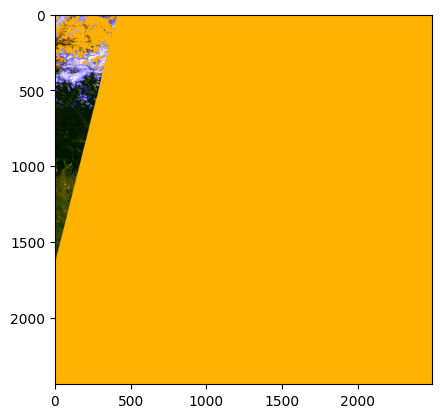

In [146]:
lms_mapping = get_suseptibility_mapping([cordinates[2][:2][1], cordinates[2][:2][0]])
plt.imshow(lms_mapping)

In [158]:
tiles = int(math.sqrt(len(cordinates)))  # Assuming len(cordinates) is a perfect square
# tiles = 2
grid_size = 2490
image_size = grid_size * tiles

large_image = np.zeros((image_size, image_size,3))

for i, bbox in tqdm(enumerate(cordinates), total=len(cordinates), desc="Processing tiles"):
    col = i // tiles
    row = i % tiles

    x_start = col * grid_size
    y_start = (tiles - 1 - row) * grid_size  # Invert row for bottom-left filling

    # Extract correct lat/lon for bounding box
    min_lon, min_lat, max_lon, max_lat = bbox
    image = get_suseptibility_mapping([min_lat, min_lon])  # Should return (2450, 2450, 3)

    # Ensure image is correctly sized
    if image.shape[:2] != (grid_size, grid_size):
        print(f"Resizing image from {image.shape} to {(grid_size, grid_size)}")
        image = cv2.resize(image, (grid_size, grid_size))  # Resize if necessary

    large_image[y_start:y_start + grid_size, x_start:x_start + grid_size, :] = image
    plt.imsave("mapping.png", large_image/255)


Processing tiles:   0%|          | 0/4 [00:00<?, ?it/s]

Resizing image from (2479, 2451, 3) to (2490, 2490)


Processing tiles:  25%|██▌       | 1/4 [00:14<00:44, 14.92s/it]

Resizing image from (2482, 2443, 3) to (2490, 2490)


Processing tiles:  50%|█████     | 2/4 [00:28<00:28, 14.09s/it]

Resizing image from (2440, 2492, 3) to (2490, 2490)


Processing tiles:  75%|███████▌  | 3/4 [00:38<00:12, 12.09s/it]

Resizing image from (2438, 2489, 3) to (2490, 2490)


Processing tiles: 100%|██████████| 4/4 [00:49<00:00, 12.43s/it]


In [140]:
grid_size

2490

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


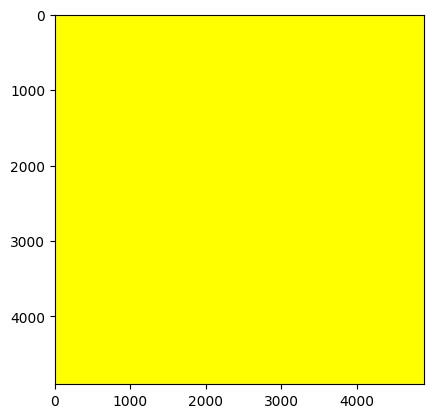

In [115]:
plt.imshow(large_image)